In [3]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import h5py
from PIL import Image
from src.benchmarkers import *
from src.benchmarkersV2 import *
from tqdm import tqdm
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from io import BytesIO

np.random.seed(0)

### Loader

In [11]:
# image 
#    |_____text
#    |_____label

#### Native resolution

In [5]:
root_path = "imagenette/imagenette2/val"
save_path = "imagenette/imagenette2/output"

In [273]:
root_path = "imagenette/imagenette2/val"
save_path = "imagenette/imagenette2/output"

classes = sorted(entry.name for entry in os.scandir(root_path) if entry.is_dir())

if not classes:
    raise FileNotFoundError(f"Couldn't find any class folder in {root_path}.")

class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

directory = os.path.expanduser(root_path)

output = []
restart = 0 

#with h5py.File(f"{save_path}/ds.h5", 'w') as f:
for j, target_class in enumerate(sorted(class_to_idx.keys())):
    class_index = class_to_idx[target_class]
    target_dir = os.path.join(directory, target_class)
    if not os.path.isdir(target_dir):
        continue
    for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)): 
        for i, fname in enumerate(sorted(fnames)):
            path = os.path.join(root, fname)
            label_index = class_index
            text = "an image of a " + target_class
            image = Image.open(path)
            buffer = BytesIO()
            image.save(buffer,format="JPEG")
            jpeg_byte_array = buffer.getvalue()
            
            sample = {
                "image_feature":[
                    {
                        "image" : jpeg_byte_array,
                        "class_feature":[
                            {
                                "label" : class_index
                            }
                        ],
                        "text_feature" : [
                            {
                                "text" : text
                            }
                        ]
                    }
                ]
            }
            output.append(sample)

                #example = f.create_group(f'example_{restart}')
                #image_feature = example.create_group('image_feature')
#
                #
                #restart += 1
                #
                ## Image 1
                #image1 = image_feature.create_group('image1')
                #im1ds = image1.create_dataset('image', data=np.array(image))  
                #im1ds.attrs["type"] = "image"
                #im1ds.attrs["label"] = class_index
#
                ## Text feature
                #text_feature = image1.create_group('text_feature')
                #txtds = text_feature.create_dataset('text', data=text)
                #txtds.attrs["type"] = "text"

table = pa.Table.from_pylist(output)
pq.write_table(table, save_path+"/ds.parquet")
        

In [6]:
table = pq.read_table(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds.parquet")
batches = table.to_batches()
with pa.OSFile(f"{save_path}/ds_stream.arrows", 'wb') as sink:  
    with pa.ipc.new_stream(sink, batches[0].schema) as writer:  
        for batch in batches:
            writer.write_batch(batch)  

In [7]:
with pa.OSFile(f"{save_path}/ds_file.arrow", 'wb') as sink:  
    with pa.ipc.new_file(sink, batches[0].schema) as writer:  
        for batch in batches:
            writer.write_batch(batch) 

In [14]:
with h5py.File(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds.h5","r") as f:
    print(len(f))

3925


### Pytorch Datasets

In [ ]:
def find_max_iterations(stringa : str,file : h5py.Dataset):
    i = 0
    j = 1
    go = True
    while go:
        dataset = file.get(stringa.replace("REPLACE",str(j)))
        if dataset:
            j = j + 1
            i = i + 1
        else:
            go = False
    return i

In [8]:
class HDF5Dataset(Dataset):

    def __init__(self, path: str , driver :str):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path
        self.f = h5py.File(self.path,"r",driver=driver)
        self.driver = driver

    def __len__(self):
        
        return len(self.f)

    def __getitem__(self, idx):

        example = self.f[f"example_{idx}"]
        image_feature = example["image_feature"]
        images = []
        labels = []
        texts = []
        for name , child in image_feature.items():
            if isinstance(child,h5py.Group):
                ds = child["image"]
                if ("type" in ds.attrs) and ds.attrs["type"] == "image":
                    imagepil = Image.fromarray(ds[:])
                    transform = transforms.Compose([
                    transforms.Lambda(lambda img: img.convert("RGB")),
                    transforms.Resize((500, 500)),  # Resize to a square shape
                    transforms.ToTensor(),          # Convert image to tensor
                    ])
                    images.append(transform(imagepil))
                    labels.append(ds.attrs["label"])
                    for name , child2 in child.items():
                        if isinstance(child2,h5py.Group): 
                            ds2 = child2["text"]
                            if ("type" in ds2.attrs) and ds2.attrs["type"] == "text":
                                texts.append(ds2[()].decode("utf-8"))

        sample = {
            "images" : images,
            "texts" : texts,
            "labels" : labels
        }

        return sample
    
    def close(self):
        self.f.close()
            

In [9]:
hdf5_ds = HDF5Dataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds.h5","core")

In [10]:
sample = hdf5_ds[3700]
print(sample["images"][0].size())

torch.Size([3, 500, 500])


In [27]:
class ArrowDataset(Dataset):

    def __init__(self, path :str, mode : str):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.path = path

        if mode == "stream_memorymap":
            with pa.memory_map(self.path, 'rb') as source:
                table = pa.ipc.open_stream(source).read_all()
                self.table = table
        
        elif mode == "file_memorymap":
            with pa.memory_map(self.path, 'rb') as source:
                table = pa.ipc.open_file(source).read_all()
                self.table = table
        
        elif mode == "stream_no_memorymap":
            with pa.OSFile(self.path, 'rb') as source:
                table = pa.ipc.open_stream(source).read_all()
                self.table = table

        elif mode == "file_no_memorymap":
            with pa.OSFile(self.path, 'rb') as source:
                table = pa.ipc.open_file(source).read_all()
                self.table = table

        elif mode == "parquet":
            table = pq.read_table(self.path)
            self.table = table

        else:
            raise NameError("mode str is not implemented. Choose between: stream_memorymap, file_memorymap, stream_no_memorymap, file_no_memorymap, parquet")

    def __len__(self):
        return len(self.table)
                            

    def __getitem__(self, idx):

        images = self.table.column("image_feature")[idx].values.field("image").to_pylist()
        labels = self.table.column("image_feature")[idx].values.field("class_feature")[0].values.field("label").to_pylist()
        texts =  self.table.column("image_feature")[idx].values.field("text_feature")[0].values.field("text").to_pylist()

        transform = transforms.Compose([
                    transforms.Lambda(lambda img: img.convert("RGB")),
                    transforms.Resize((500, 500)),  # Resize to a square shape
                    transforms.ToTensor(),          # Convert image to tensor
                    ])

        images = [transform(Image.open(BytesIO(item))) for item in images]

        sample = {
            "images" : images,
            "texts" : texts,
            "labels" : labels
        }

        return sample

In [28]:
arrow_ds = ArrowDataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds_file.arrow","file_memorymap")

In [29]:
new_image = arrow_ds[0]["images"]

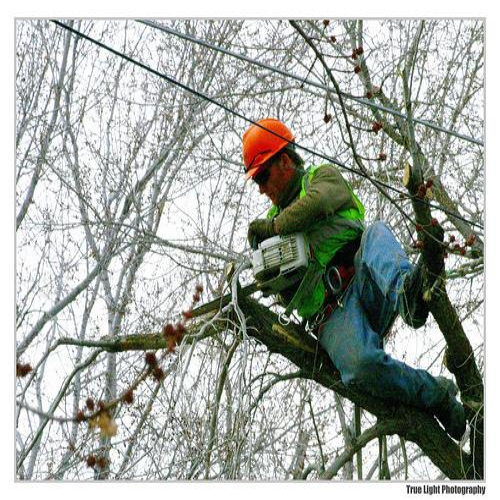

In [31]:
transforms.ToPILImage()(new_image[0])

### Resnet classification benchmark

In [59]:
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification

batch_size = 64
shuffle = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model.to(device)
model.eval()

In [53]:
def resnet_collate(batch):
    images = [item["images"][0] for item in batch]
    labels =  [item["labels"][0] for item in batch]
    try:
        images_tensor = torch.stack(images)
    except RuntimeError:
        print(f"sono il debugger:{[i.shape for i in images]}")

    labels_tensor = torch.tensor(labels)  

    return images_tensor,labels_tensor


In [42]:
dataset = ArrowDataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds_stream.arrows","stream_memorymap")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)


total_time = []

for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/stream_memory_arrow.npy",np.array([mean,std_dev]))


In [ ]:
dataset = ArrowDataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds_file.arrow","file_memorymap")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)


total_time = []

for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/file_memory_arrow.npy",np.array([mean,std_dev]))

In [ ]:
dataset = ArrowDataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds_stream.arrows","stream_no_memorymap")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)

total_time = []
for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/stream_no_memory_arrow.npy",np.array([mean,std_dev]))

In [ ]:
dataset = ArrowDataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds_file.arrow","file_no_memorymap")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)


total_time = []
for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/file_no_memory_arrow.npy",np.array([mean,std_dev]))

In [ ]:
dataset = ArrowDataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds.parquet","parquet")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)

total_time = []

for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/parquet.npy",np.array([mean,std_dev]))

In [ ]:
dataset = HDF5Dataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds.h5","core")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model.to(device)
model.eval()

total_time = []
for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/hdf5_core.npy",np.array([mean,std_dev]))

In [ ]:
dataset = HDF5Dataset(r"C:\Users\Cristiano Lavoro\Desktop\benchmarks\imagenette\imagenette2\output\ds.h5","sec2")
dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,collate_fn=resnet_collate)

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
model.to(device)
model.eval()

total_time = []
for X,Y in dataloader:
    start = time.time()
    X = X.to(device)
    inputs = processor(X, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_label = logits.argmax(-1).item()
        end = time.time()
        total_time.append(end-start)
        print(model.config.id2label[predicted_label])
        print(Y)

mean = np.mean(total_time)
std_dev = np.std(total_time)
np.save("imagenette2/results/hdf5_sec2.npy",np.array([mean,std_dev]))

### CLIP zero shot classification benchmark